Look at the evolution of the sky coverage.  If a template image has to come from a same-vendor chip, it takes longer to build up the sky template archive. 

We set up a chip layout and then compute various metrics as a function of time for just chips from a single vendor. Thne we find how many days it takes the survey to survey 20,000 sq degrees for each chip vendor.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
import healpy as hp

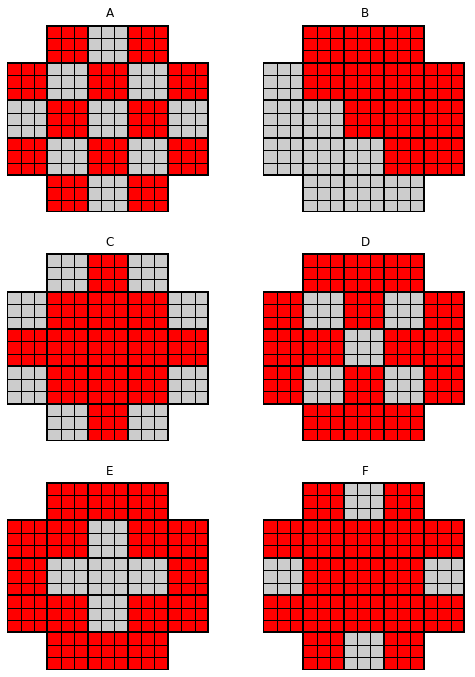

In [2]:
def drawRaft(ax, xLL, yLL, color='#CCCCCC', width = 1.0, height = 1.0, plotCCDs = 1):

    ax.add_patch(Rectangle((yLL, xLL), width, height, fill=True, color=color, ec='k'))
    # raft frame
    ax.plot([xLL, xLL], [yLL, yLL+height], 'black', linewidth=2)
    ax.plot([xLL+width, xLL+width], [yLL, yLL+height], 'black', linewidth=2)
    ax.plot([xLL, xLL+width], [yLL, yLL], 'black', linewidth=2)
    ax.plot([xLL, xLL+width], [yLL+height, yLL+height], 'black', linewidth=2)

    if plotCCDs: 
        ax.plot([xLL+width/3.0, xLL+width/3.0], [yLL, yLL+height], 'black', linewidth=1)
        ax.plot([xLL+2*width/3.0, xLL+2*width/3.0], [yLL, yLL+height], 'black', linewidth=1)
        ax.plot([xLL, xLL+width], [yLL+height/3.0, yLL+height/3.0], 'black', linewidth=1)
        ax.plot([xLL, xLL+width], [yLL+2*height/3.0, yLL+2*height/3.0], 'black', linewidth=1)

def plotHybridFOV(axes, option):

    # title 
    axes.set_title(option)

    # axes limits
    axes.set_xlim(0, 5.1)
    axes.set_ylim(0, 5.1)

    for i in (1, 2, 3): 
        for j in range(0,5):
            drawRaft(axes, i, j, color = 'red')
    for i in (0, 4): 
        for j in range(1,4):
            drawRaft(axes, i, j, color = 'red')
            
    if (option == 'A'):
        drawRaft(axes, 0, 2)
        drawRaft(axes, 1, 1)
        drawRaft(axes, 1, 3)
        drawRaft(axes, 2, 0)
        drawRaft(axes, 2, 2)
        drawRaft(axes, 2, 4)
        drawRaft(axes, 3, 1)
        drawRaft(axes, 3, 3)
        drawRaft(axes, 4, 2)

    if (option == 'B'):
        drawRaft(axes, 0, 1)
        drawRaft(axes, 0, 2)
        drawRaft(axes, 0, 3)
        drawRaft(axes, 1, 0)
        drawRaft(axes, 1, 1)
        drawRaft(axes, 1, 2)
        drawRaft(axes, 2, 0)
        drawRaft(axes, 2, 1)
        drawRaft(axes, 3, 0)

    if (option == 'C'):
        drawRaft(axes, 0, 1)
        drawRaft(axes, 0, 3)
        drawRaft(axes, 1, 0)
        drawRaft(axes, 1, 4)
        drawRaft(axes, 3, 0)
        drawRaft(axes, 3, 4)
        drawRaft(axes, 4, 1)
        drawRaft(axes, 4, 3)

    if (option == 'D'):
        drawRaft(axes, 1, 1)
        drawRaft(axes, 1, 3)
        drawRaft(axes, 2, 2)
        drawRaft(axes, 3, 1)
        drawRaft(axes, 3, 3)

    if (option == 'E'):
        drawRaft(axes, 1, 2)
        drawRaft(axes, 2, 1)
        drawRaft(axes, 2, 2)
        drawRaft(axes, 2, 3)
        drawRaft(axes, 3, 2)

    if (option == 'F'):
        drawRaft(axes, 0, 2)
        drawRaft(axes, 2, 0)
        drawRaft(axes, 2, 4)
        drawRaft(axes, 4, 2)
     

### plot a 6-panel figure with hybrid focal plane realizations
def plotHybridFOVoptions(): 

    # Create figure and subplots
    fig = plt.figure(figsize=(8, 10))
    # this work well in *.py version but not so well in ipython notebook
    fig.subplots_adjust(wspace=0.25, left=0.1, right=0.9, bottom=0.05, top=0.95)

    optionsList = ('A', 'B', 'C', 'D', 'E', 'F')
    plotNo = 0
    for option in optionsList:
        plotNo += 1
        axes = plt.subplot(3, 2, plotNo, xticks=[], yticks=[], frameon=False)
        plotHybridFOV(axes, option)

    #plt.savefig('./HybridFOVoptions.png')
    plt.show() 


### 
plotHybridFOVoptions()

In [3]:
# Set up each configuration to return a list of chips in a way MAF understands
# Let's do this for a hybrid focal plane
def makeChipList(raftConfig):
    """
    Return the chip lists for different vendor configurations.
    """
    raftDict = {'R:1,0':1,
                'R:2,0':2 ,
                'R:3,0':3 ,
                'R:0,1':4 ,
                'R:1,1':5 ,
                'R:2,1':6 ,
                'R:3,1':7 ,
                'R:4,1':8 ,
                'R:0,2':9 ,
                'R:1,2':10,
                'R:2,2':11,
                'R:3,2':12,
                'R:4,2':13,
                'R:0,3':14,
                'R:1,3':15,
                'R:2,3':16,
                'R:3,3':17,
                'R:4,3':18,
                'R:1,4':19,
                'R:2,4':20,
                'R:3,4':21}

    sensors = ['S:0,0', 'S:0,1', 'S:0,2',
               'S:1,0', 'S:1,1', 'S:1,2',
               'S:2,0', 'S:2,1', 'S:2,2',]


    raftReverseDict = {}
    for key in raftDict:
        raftReverseDict[raftDict[key]] = key
    raftConfigs = {'A':{'rafts2':[1,3,4,6,8,10,12,14,16,18,19,21], 'rafts1':[2,5,7,9,11,13,15,17,20]},
                   'B':{'rafts2':[7,8,11,12,13,15,16,17,18,19,20,21], 'rafts1':[1,2,3,4,5,6,9,10,14]},
                   'C':{'rafts2':[2,5,6,7,9,10,11,12,13,15,16,17,20], 'rafts1':[1,3,4,8,14,18,19,21]},
                   'D':{'rafts2':[1,2,3,4,6,8,9,10,12,13,14,16,18,19,20,21], 'rafts1':[5,7,11,15,17]},
                   'E':{'rafts2':[1,2,3,4,5,7,8,9,13,14,15,17,18,19,20,21], 'rafts1':[6,10,11,12,16]},
                   'F':{'rafts2':[1,2,3,4,5,7,8,9,13,14,15,17,18,19,20,21], 'rafts1':[6,10,11,12,16]}
                  }
    rafts1 = []
    rafts2 = []
    for indx in raftConfigs[raftConfig]['rafts1']:
        rafts1.append(raftReverseDict[indx])

    for indx in raftConfigs[raftConfig]['rafts2']:
        rafts2.append(raftReverseDict[indx])

    chips1 = []
    for raft in rafts1:
        for sensor in sensors:
            chips1.append(raft+' '+sensor)

    chips2 = []
    for raft in rafts2:
        for sensor in sensors:
            chips2.append(raft+' '+sensor)
    return chips1, chips2

In [4]:
database = 'enigma_1189_sqlite.db'
opsdb = db.OpsimDatabase(database)
outDir = 'Template'
resultsDb = db.ResultsDb(outDir=outDir)
nside = 128

In [5]:
def timeToArea(metricValues, area=20000, nside=128):
    """
    compute how many night it took to reach the area limit (sq degrees)
    """
    pixArea = hp.nside2pixarea(nside, degrees=True)
    tmp = metricValues.copy()
    tmp[np.where(tmp > 0)] = 1
    tmp = np.sum(tmp, axis=0)
    tmp *= pixArea
    overLimit = np.where(tmp > area)[0]
    if np.size(overLimit) > 0:
        return np.min(overLimit)
    else:
        return -1


In [7]:

raftLayout = 'E'
filters = ['u','g']
for filtername in filters:
    bundleList = []
    chips1, chips2 = makeChipList(raftLayout)
    years = 5
    # Select the filter and the number of years
    sqlWhere = 'filter = "%s" and night < %i' %(filtername, 365.25*years)
    metric = metrics.AccumulateCountMetric(bins=np.arange(0,365.25*years,1))
    # Use only chips from vendor 1
    slicer = slicers.HealpixSlicer(nside=nside, latCol='ditheredDec', lonCol='ditheredRA', useCamera=True, chipNames=chips1)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlWhere, metadata='Chips1, %s' % raftLayout))
    # Use only chips from vendor 2
    slicer = slicers.HealpixSlicer(nside=nside, latCol='ditheredDec', lonCol='ditheredRA', useCamera=True, chipNames=chips2)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlWhere, metadata='Chips2, %s' % raftLayout))
    # Use all chips
    slicer = slicers.HealpixSlicer(nside=nside, latCol='ditheredDec', lonCol='ditheredRA', useCamera=True)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlWhere, metadata='SingleVendor'))
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd,opsdb, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    for bundle in bundleList:
        print bundle.metadata, ',filter='+filtername, 'days to 20,000 sq deg covered = ', timeToArea(bundle.metricValues, nside=nside, area=20000)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database with constraint filter = "u" and night < 1826
Found 91228 visits
Running:  ['opsim_AccumulateCount_night_night_Chips2_E_HEAL']
Completed metric generation.
Running:  ['opsim_AccumulateCount_night_night_SingleVendor_HEAL']
Completed metric generation.
Running:  ['opsim_AccumulateCount_night_night_Chips1_E_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Chips1, E ,filter=u days to 20,000 sq deg covered =  863
Chips2, E ,filter=u days to 20,000 sq deg covered =  365
SingleVendor ,filter=u days to 20,000 sq deg covered =  273
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NS